In [43]:
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
import os

In [44]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Defining globals

In [45]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
EPOCHS = 30
class_names = ["chihuahua", "muffin"]

In [46]:
def predict_image(model, name, url):
    full_path = os.path.abspath(url)
    path = tf.keras.utils.get_file(name, "file://" + full_path)

    img = tf.keras.utils.load_img(
        path, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print("{} most likely belongs to {} with a {:.2f} percent confidence."
          .format(name, class_names[np.argmax(score)], 100 * np.max(score)))

def test_prediction(model):
    predict_image(model, "Red_Sunflower", "./test/sunflower.jpg")
    predict_image(model, "Chihuahua", "./test/chihuahua.jpg")
    predict_image(model, "Chihuahua_with_blanket", "./test/chihuahua_blanket.jpg")
    predict_image(model, "Chihuahua Cookie", "./test/chihuahu_blueberry.jpg")
    predict_image(model, "Muffin", "./test/muffin.jpg")
    predict_image(model, "Chocolate_Muffins", "./test/chocolate_muffins.jpg")
    predict_image(model, "Chocolate_Muffin2", "./test/chocolate_muffin2.jpg")
    predict_image(model, "Blueberry_Muffin", "./test/blueberry_muffins.jpg")

## Training-Test Split

In [47]:
train_dir = "./data"
batch_size = 32

training_data = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  labels='inferred',  
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

validation_data = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  labels='inferred',  
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

Found 5917 files belonging to 2 classes.
Using 4734 files for training.
Found 5917 files belonging to 2 classes.
Using 1183 files for validation.


In [48]:
AUTOTUNE = tf.data.AUTOTUNE

training_data = training_data.cache().shuffle(6000).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

## Running a pretrained model

In [49]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(
        include_top=False,
        pooling='max',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        weights='imagenet')

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(2, 'softmax')
])

base_model.trainable = False
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dense_10 (Dense)            (None, 2)                 514       
                                                                 
Total params: 24745730 (94.40 MB)
Trainable params: 1180930 (4.50 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


### Preprocessing

In [50]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])
data_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
])
model = tf.keras.Sequential([
  data_preprocessing,
  data_augmentation,
  #tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  #tf.keras.layers.MaxPooling2D(),
  model
])

In [51]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [52]:
history = model.fit(
  training_data,
  validation_data=validation_data,
  epochs=EPOCHS
)

Epoch 1/30
148/148 [==============================] - 21s 104ms/step - loss: 0.4211 - accuracy: 0.9692 - val_loss: 0.1176 - val_accuracy: 0.9932
Epoch 2/30
148/148 [==============================] - 15s 100ms/step - loss: 0.0907 - accuracy: 0.9833 - val_loss: 0.0979 - val_accuracy: 0.9865
Epoch 3/30
148/148 [==============================] - 14s 96ms/step - loss: 0.0829 - accuracy: 0.9867 - val_loss: 0.0966 - val_accuracy: 0.9822
Epoch 4/30
148/148 [==============================] - 14s 96ms/step - loss: 0.0370 - accuracy: 0.9886 - val_loss: 0.0671 - val_accuracy: 0.9890
Epoch 5/30
148/148 [==============================] - 14s 97ms/step - loss: 0.0381 - accuracy: 0.9886 - val_loss: 0.0360 - val_accuracy: 0.9915
Epoch 6/30
148/148 [==============================] - 14s 98ms/step - loss: 0.0234 - accuracy: 0.9926 - val_loss: 0.0819 - val_accuracy: 0.9915
Epoch 7/30
148/148 [==============================] - 14s 98ms/step - loss: 0.0324 - accuracy: 0.9903 - val_loss: 0.1216 - val_accurac

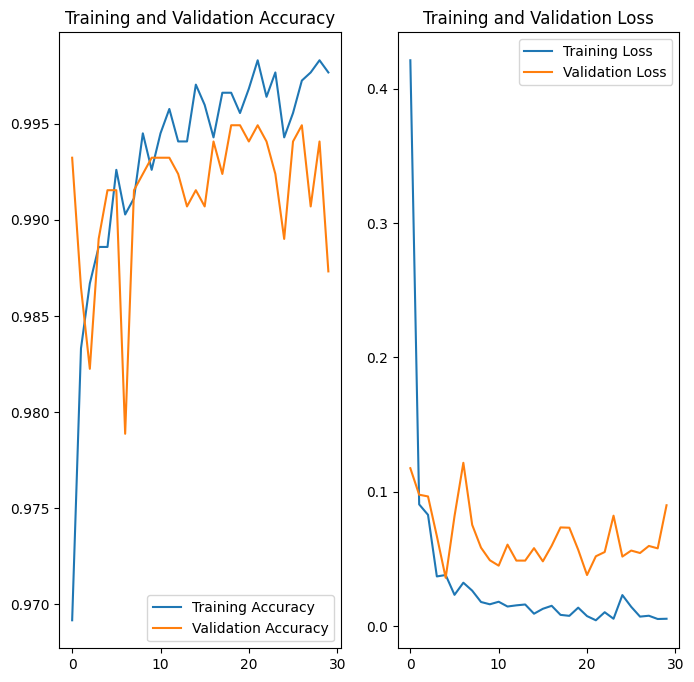

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
test_prediction(model)

1/1 [==============================] - 0s 480ms/step
Red_Sunflower most likely belongs to chihuahua with a 63.51 percent confidence.
1/1 [==============================] - 0s 15ms/step
Chihuahua most likely belongs to chihuahua with a 73.11 percent confidence.
1/1 [==============================] - 0s 18ms/step
Chihuahua_with_blanket most likely belongs to chihuahua with a 73.11 percent confidence.
1/1 [==============================] - 0s 16ms/step
Chihuahua Cookie most likely belongs to chihuahua with a 70.41 percent confidence.
1/1 [==============================] - 0s 16ms/step
Muffin most likely belongs to muffin with a 73.11 percent confidence.
1/1 [==============================] - 0s 16ms/step
Chocolate_Muffins most likely belongs to muffin with a 73.11 percent confidence.
1/1 [==============================] - 0s 16ms/step
Chocolate_Muffin2 most likely belongs to muffin with a 73.11 percent confidence.
1/1 [==============================] - 0s 16ms/step
Blueberry_Muffin most l

## Experiment: Training a custom model yields better results

In [55]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    tf.keras.layers.Convolution2D(filters=16, kernel_size=(5,5)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    tf.keras.layers.Convolution2D(filters=32, kernel_size=(5,5)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Convolution2D(filters=64, kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Convolution2D(filters=128, kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    tf.keras.layers.Convolution2D(filters=256, kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    tf.keras.layers.Flatten(),
            
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 220, 220, 16)      1216      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 53, 53, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_7 (Conv2D)           (None, 51, 51, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 25, 25, 64)      

In [56]:
model = tf.keras.Sequential([
  data_preprocessing,
  data_augmentation,
  #tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  #tf.keras.layers.MaxPooling2D(),
  model
])

In [57]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [58]:
history = model.fit(
  training_data,
  validation_data=validation_data,
  epochs=EPOCHS
)

Epoch 1/30
148/148 [==============================] - 7s 38ms/step - loss: 0.5239 - accuracy: 0.7590 - val_loss: 0.5385 - val_accuracy: 0.7481
Epoch 2/30
148/148 [==============================] - 5s 37ms/step - loss: 0.4392 - accuracy: 0.8101 - val_loss: 0.3907 - val_accuracy: 0.8622
Epoch 3/30
148/148 [==============================] - 5s 36ms/step - loss: 0.3955 - accuracy: 0.8376 - val_loss: 0.4072 - val_accuracy: 0.8242
Epoch 4/30
148/148 [==============================] - 5s 36ms/step - loss: 0.3775 - accuracy: 0.8405 - val_loss: 0.3392 - val_accuracy: 0.8673
Epoch 5/30
148/148 [==============================] - 5s 36ms/step - loss: 0.3507 - accuracy: 0.8566 - val_loss: 0.3618 - val_accuracy: 0.8588
Epoch 6/30
148/148 [==============================] - 5s 33ms/step - loss: 0.3442 - accuracy: 0.8606 - val_loss: 0.3348 - val_accuracy: 0.8605
Epoch 7/30
148/148 [==============================] - 5s 33ms/step - loss: 0.3295 - accuracy: 0.8659 - val_loss: 0.3787 - val_accuracy: 0.8309

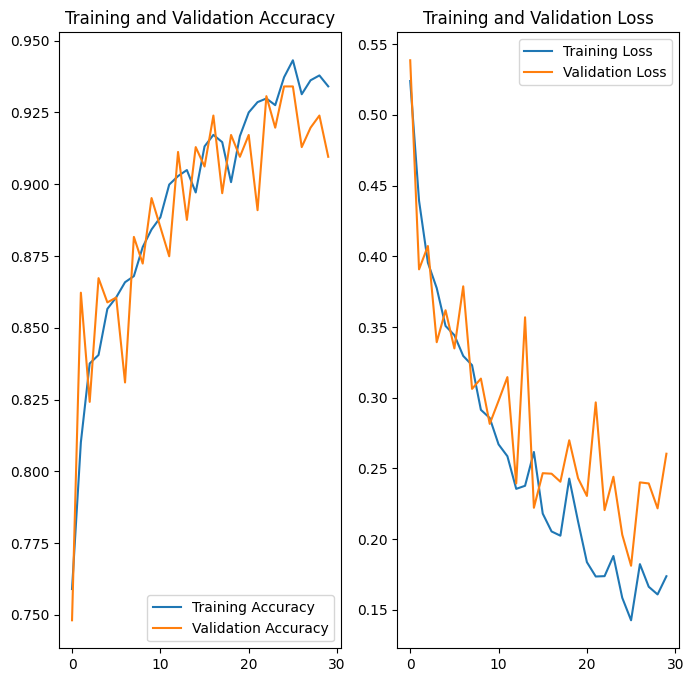

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
test_prediction(model)

1/1 [==============================] - 0s 57ms/step
Red_Sunflower most likely belongs to muffin with a 55.19 percent confidence.
1/1 [==============================] - 0s 12ms/step
Chihuahua most likely belongs to chihuahua with a 73.10 percent confidence.
1/1 [==============================] - 0s 12ms/step
Chihuahua_with_blanket most likely belongs to chihuahua with a 73.09 percent confidence.
1/1 [==============================] - 0s 12ms/step
Chihuahua Cookie most likely belongs to chihuahua with a 73.09 percent confidence.
1/1 [==============================] - 0s 12ms/step
Muffin most likely belongs to chihuahua with a 54.13 percent confidence.
1/1 [==============================] - 0s 11ms/step
Chocolate_Muffins most likely belongs to muffin with a 71.14 percent confidence.
1/1 [==============================] - 0s 12ms/step
Chocolate_Muffin2 most likely belongs to chihuahua with a 58.85 percent confidence.
1/1 [==============================] - 0s 14ms/step
Blueberry_Muffin most

## Results

The pretrained model detects with higher accuracy.  
The custom model detects Muffin as well as Chocolate_Muffin2 wrongly as a Chihuahua.